# Intepretability on Hateful Twitter Datasets

In this demo, we apply saliency maps (with support of sparse tensors) on the task on the detection of Twitter users who use hateful lexicon using graph machine learning with Stellargraph.

We consider the use-case of identifying hateful users on Twitter motivated by the work in [1] and using the dataset also published in [1]. Classification is based on a graph based on users' retweets and attributes as related to their account activity, and the content of tweets.

We pose identifying hateful users as a binary classification problem. We demonstrate the advantage of connected vs unconnected data in a semi-supervised setting with few training examples.

For connected data, we use Graph Convolutional Networks [2] as implemented in the `stellargraph` library. We pose the problem of identifying hateful tweeter users as node attribute inference in graphs.

We then use the interpretability tool (i.e., saliency maps) implemented in our library to demonstrate how to interpret the node features and links 

**References**

1. "Like Sheep Among Wolves": Characterizing Hateful Users on Twitter. M. H. Ribeiro, P. H. Calais, Y. A. Santos, V. A. F. Almeida, and W. Meira Jr.  arXiv preprint arXiv:1801.00317 (2017).


2. Semi-Supervised Classification with Graph Convolutional Networks. T. Kipf, M. Welling. ICLR 2017. arXiv:1609.02907 


In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import os

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegressionCV

import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator, FullBatchNodeGenerator
from stellargraph.layer import GraphSAGE, GCN, GAT
from stellargraph import globalvar

from keras import layers, optimizers, losses, metrics, Model, models
from sklearn import preprocessing, feature_extraction
from sklearn.model_selection import train_test_split
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

def remove_prefix(text, prefix):
    return text[text.startswith(prefix) and len(prefix):]

def plot_history(history):
    metrics = sorted(set([remove_prefix(m, "val_") for m in list(history.history.keys())]))
    for m in metrics:
        # summarize history for metric m
        plt.plot(history.history[m])
        plt.plot(history.history['val_' + m])
        plt.title(m, fontsize=18)
        plt.ylabel(m, fontsize=18)
        plt.xlabel('epoch', fontsize=18)
        plt.legend(['train', 'validation'], loc='best')
        plt.show()


### Loading the data

**Downloading the dataset:**

The dataset for this demo was published in [1] and it is freely available to download from Kaggle [here](https://www.kaggle.com/manoelribeiro/hateful-users-on-twitter/home).

The following is the description of the datasets:

>This dataset contains a network of 100k users, out of which ~5k were annotated as hateful or
>not. For each user, several content-related, network-related and activity related features
>were provided. 

Additional files of hateful lexicon can be found [here]( 
https://github.com/manoelhortaribeiro/HatefulUsersTwitter/tree/master/data/extra)

Download the dataset and then set the `data_dir` variable to point to the download location.

In [3]:
data_dir = os.path.expanduser("~/data/hateful-twitter-users")

### First load and prepare the node features

Each node in the graph is associated with a large number of features (also referred to as attributes). 

The list of features is given [here](https://www.kaggle.com/manoelribeiro/hateful-users-on-twitter). We repeated here for convenience.

hate :("hateful"|"normal"|"other")
  if user was annotated as hateful, normal, or not annotated.
  
  (is_50|is_50_2) :bool
  whether user was deleted up to 12/12/17 or 14/01/18. 
  
  (is_63|is_63_2) :bool
  whether user was suspended up to 12/12/17 or 14/01/18. 
        
  (hate|normal)_neigh :bool
  is the user on the neighborhood of a (hateful|normal) user? 
  
  [c_] (statuses|follower|followees|favorites)_count :int
  number of (tweets|follower|followees|favorites) a user has.
  
  [c_] listed_count:int
  number of lists a user is in.

  [c_] (betweenness|eigenvector|in_degree|outdegree) :float
  centrality measurements for each user in the retweet graph.
  
  [c_] *_empath :float
  occurrences of empath categories in the users latest 200 tweets.

  [c_] *_glove :float          
  glove vector calculated for users latest 200 tweets.
  
  [c_] (sentiment|subjectivity) :float
  average sentiment and subjectivity of users tweets.
  
  [c_] (time_diff|time_diff_median) :float
  average and median time difference between tweets.
  
  [c_] (tweet|retweet|quote) number :float
  percentage of direct tweets, retweets and quotes of an user.
  
  [c_] (number urls|number hashtags|baddies|mentions) :float
  number of bad words|mentions|urls|hashtags per tweet in average.
  
  [c_] status length :float
  average status length.
  
  hashtags :string
  all hashtags employed by the user separated by spaces.
  
**Notice** that c_ are attributes calculated for the 1-neighborhood of a user in the retweet network (averaged out).

First, we are going to load the user features and prepare them for machine learning.

In [4]:
users_feat = pd.read_csv(os.path.join(data_dir, 
                                      'users_neighborhood_anon.csv'))
users_feat.head()

,user_id,hate,hate_neigh,normal_neigh,statuses_count,followers_count,followees_count,favorites_count,listed_count,betweenness,...,c_feminine_empath,c_medieval_empath,c_journalism_empath,c_farming_empath,c_plant_empath,c_shopping_empath,c_ship_empath,c_religion_empath,c_tourism_empath,c_power_empath
0,0,normal,True,True,101767,3504,3673,81635,53,100467.895084,...,0.001380,0.003288,0.000255,0.002189,0.000593,0.003689,0.003559,0.001634,0.002662,0.007487
1,1,other,False,False,2352,19609,309,61,197,0.000000,...,0.000802,0.004465,0.000444,0.001632,0.001298,0.002183,0.008969,0.004975,0.000647,0.003419
2,2,other,False,False,1044,2371,2246,561,16,4897.117853,...,0.000985,0.005284,0.000554,0.001084,0.001359,0.002041,0.016846,0.004881,0.001214,0.003347
3,3,other,False,False,167172,3004,298,3242,53,9.864754,...,0.001391,0.002061,0.001116,0.001282,0.000000,0.001951,0.015423,0.000446,0.000446,0.005241
4,4,other,False,False,1998,17643,19355,485,239,0.000000,...,0.000633,0.035382,0.000317,0.000475,0.000475,0.002431,0.007656,0.033273,0.072792,0.003698


Let's have a look at the distribution of hateful, normal (not hateful), and other (unknown) users in the dataset

In [5]:
print("Initial hateful/normal users distribution")
print(users_feat.shape)
print(users_feat.hate.value_counts())

Initial hateful/normal users distribution
(100386, 1039)
other      95415
normal      4427
hateful      544
Name: hate, dtype: int64


There is a clear imbalance on the number of users tagged as hateful vs normal and unknown.

### Data cleaning and preprocessing

The dataset as given includes a large number of graph related features that are manually extracted. 

Since we are going to employ modern graph neural networks methods for classification, we are going to drop these manually engineered features. 

The power of Graph Neural Networks stems from their ability to learn useful graph-related features eliminating the need for manual feature engineering.

In [6]:
def data_cleaning(feat):
    feat = feat.drop(columns=["hate_neigh", "normal_neigh"])
    
    # Convert target values in hate column from strings to integers (0,1,2)
    feat['hate'] = np.where(feat['hate']=='hateful', 1, np.where(feat['hate']=='normal', 0, 2))
    
    # missing information
    number_of_missing = feat.isnull().sum()
    number_of_missing[number_of_missing!=0]
    
    # Replace NA with 0
    feat.fillna(0, inplace=True)

    # droping info about suspension and deletion as it is should not be use din the predictive model
    feat.drop(feat.columns[feat.columns.str.contains("is_")], axis=1, inplace=True)

    # drop glove features
    feat.drop(feat.columns[feat.columns.str.contains("_glove")], axis=1, inplace=True)

    # drop c_ features
    feat.drop(feat.columns[feat.columns.str.contains("c_")], axis=1, inplace=True)

    # drop sentiment features for now
    feat.drop(feat.columns[feat.columns.str.contains("sentiment")], axis=1, inplace=True)

    # drop hashtag feature
    feat.drop(['hashtags'], axis=1, inplace=True)

    # Drop centrality based measures
    feat.drop(columns=['betweenness', 'eigenvector', 'in_degree', 'out_degree'], inplace=True)
    
    feat.drop(columns=['created_at'], inplace=True)
    
    return feat

In [7]:
node_data = data_cleaning(users_feat)

Of the original **1037** node features, we are keeping only **204** that are based on a user's attributes and tweet lexicon. We have removed any manually engineered graph features since the graph neural network algorithms we are going to use will automatically determine the best features to use during training.

In [8]:
node_data.shape

(100386, 206)

In [9]:
node_data.head()

,user_id,hate,statuses_count,followers_count,followees_count,favorites_count,listed_count,negotiate_empath,vehicle_empath,science_empath,...,number hashtags,tweet number,retweet number,quote number,status length,number urls,baddies,mentions,time_diff,time_diff_median
0,0,0,101767,3504,3673,81635,53,0.000513,0.002564,0.002564,...,16.0,121.0,79.0,5.0,75.565000,82.0,18.0,159.0,356.020101,74.0
1,1,2,2352,19609,309,61,197,0.003180,0.000867,0.003469,...,40.0,199.0,0.0,0.0,101.713568,20.0,10.0,6.0,17519.116162,45.0
2,2,2,1044,2371,2246,561,16,0.005272,0.000000,0.005272,...,328.0,113.0,87.0,0.0,128.130000,219.0,16.0,158.0,46417.758794,2010.0
3,3,2,167172,3004,298,3242,53,0.004016,0.005801,0.001339,...,127.0,69.0,131.0,3.0,85.760000,149.0,10.0,26.0,656.889447,72.0
4,4,2,1998,17643,19355,485,239,0.001134,0.000000,0.000756,...,1710.0,101.0,99.0,0.0,152.175000,198.0,35.0,7.0,55991.356784,48197.0


The continous features in our dataset have distributions with very long tails. We apply normalization to correct for this.

In [10]:
# Ignore the first two columns because those are user_id and hate (the target variable)
df_values = node_data.iloc[:, 2:].values

In [11]:
pt = preprocessing.PowerTransformer(method='yeo-johnson', 
                                    standardize=True) 

In [12]:
df_values_log = pt.fit_transform(df_values)

Let's have a look at one of the normalized features before and after the power transform was applied.

The feature we are going to look at is a user's number of followers.

In [13]:
sns_rc = {'lines.linewidth': 3, 'figure.figsize':(12,6)}
sns.set_context("paper", rc = sns_rc) 
sns.set_style("whitegrid", {'axes.grid' : False})

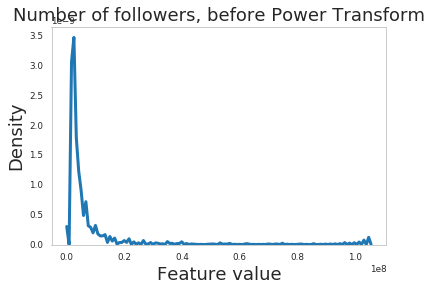

In [14]:
sns.kdeplot(df_values[:, 1])
s = plt.ylabel("Density", fontsize=18)
s = plt.xlabel("Feature value", fontsize=18)
s = plt.title("Number of followers, before Power Transform", fontsize=18)

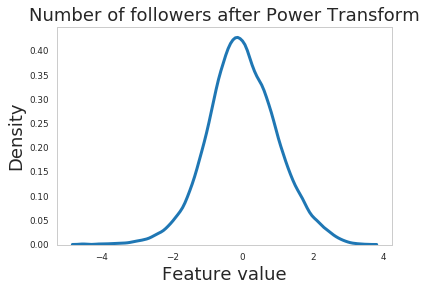

In [15]:
sns.kdeplot(df_values_log[:, 1])
s = plt.ylabel("Density", fontsize=18)
s = plt.xlabel("Feature value", fontsize=18)
s = plt.title("Number of followers after Power Transform", fontsize=18)

Feature normalization looks like it is doing the right thing as the raw features have long tails that are eliminated after applying the power transform. 

So let us use the normalized features from now on.

In [16]:
node_data.iloc[:, 2:] = df_values_log

In [17]:
# Set the dataframe index to be the same as the user_id and drop the user_id columns
node_data.index = node_data.index.map(str)
node_data.drop(columns=['user_id'], inplace=True)

Node features are now ready for machine learning.

In [18]:
node_data.head()

,hate,statuses_count,followers_count,followees_count,favorites_count,listed_count,negotiate_empath,vehicle_empath,science_empath,timidity_empath,...,number hashtags,tweet number,retweet number,quote number,status length,number urls,baddies,mentions,time_diff,time_diff_median
0,0,1.541150,0.046773,1.104767,1.869391,0.017835,-1.752256,0.164900,0.181173,0.875069,...,-0.632488,-0.049013,0.321929,-0.369992,-1.036127,-0.796091,0.047430,0.356495,-1.888186,-1.299249
1,2,-0.700240,0.772450,-0.526061,-1.434183,0.613187,-0.735320,-0.864337,0.599279,1.610977,...,-0.071721,1.479066,-1.999580,-1.545285,-0.188945,-1.875745,-0.626192,-1.972207,0.160925,-1.512603
2,2,-1.077284,-0.127775,0.767345,-0.669050,-0.523882,-0.118440,-1.573040,1.211083,-0.154213,...,1.618609,-0.201320,0.452537,-1.545285,0.637869,0.884530,-0.096918,0.348954,0.698841,0.122176
3,2,1.908494,-0.021575,-0.548705,0.078540,0.017835,-0.472125,1.281633,-0.544862,1.259492,...,0.781915,-1.018822,1.085858,-0.662393,-0.701835,0.088472,-0.626192,-1.254997,-1.576801,-1.311031
4,2,-0.778589,0.729918,2.296049,-0.725089,0.700128,-1.488804,-1.573040,-0.969812,0.199834,...,3.422701,-0.427866,0.638106,-1.545285,1.370832,0.655433,0.955922,-1.914894,0.803553,1.472247


### Next load the graph

Now that we have the node features prepared for machine learning, let us load the retweet graph.

In [19]:
g_nx = nx.read_edgelist(path=os.path.expanduser(os.path.join(data_dir,
                                                             "users.edges")))

In [20]:
g_nx.number_of_nodes(), g_nx.number_of_edges()

(100386, 2194979)

The graph has just over 100k nodes and approximately 2.2m edges.

We aim to train a graph neural network model that will predict the "hate"attribute on the nodes.

For computation convenience, we have mapped the target labels **normal**, **hateful**, and **other** to the numeric values **0**, **1**, and **2** respectively.

In [21]:
print(set(node_data["hate"]))

{0, 1, 2}


### Splitting the data

For machine learning we want to take a subset of the nodes for training, and use the rest for validation and testing. We'll use scikit-learn again to split our data into training and test sets.

The total number of annotated nodes is very small when compared to the total number of nodes in the graph. We are only going to use 15% of the annotated nodes for training and the remaining 85% of nodes for testing.

First, we are going to select the subset of nodes that are annotated as hateful or normal. These will be the nodes that have 'hate' values that are either 0 or 1.

In [22]:
# choose the nodes annotated with normal or hateful classes
annotated_users = node_data[node_data['hate']!=2]

In [23]:
annotated_users.head()

,hate,statuses_count,followers_count,followees_count,favorites_count,listed_count,negotiate_empath,vehicle_empath,science_empath,timidity_empath,...,number hashtags,tweet number,retweet number,quote number,status length,number urls,baddies,mentions,time_diff,time_diff_median
0,0,1.541150,0.046773,1.104767,1.869391,0.017835,-1.752256,0.164900,0.181173,0.875069,...,-0.632488,-0.049013,0.321929,-0.369992,-1.036127,-0.796091,0.047430,0.356495,-1.888186,-1.299249
22,0,1.610235,-0.311474,0.224841,-1.350517,-0.883454,-1.178383,-1.035463,-0.172829,-0.253731,...,-1.291040,1.239586,-1.215177,1.557857,-1.689390,-0.914795,-0.023220,-0.029203,-0.850158,-1.073416
29,0,0.676296,0.907563,-0.583110,-0.473819,1.029022,0.133058,-0.272510,0.154618,1.168792,...,-0.448834,1.060920,-0.907346,0.969577,0.747312,-0.432903,0.529664,0.791479,-0.834524,-0.737971
44,0,-0.564326,-0.167266,0.174262,-0.364344,-0.689414,0.560514,-0.332782,0.226878,1.359779,...,0.483518,-1.269935,1.264966,-0.254387,0.863865,0.543677,0.047430,0.661312,0.758658,1.137312
85,0,1.036340,-0.137409,-0.777300,1.135700,-0.145647,-0.882219,-1.107841,1.624682,0.028468,...,-0.476405,0.374573,-0.074243,0.355409,-0.302047,-0.340005,-0.524781,0.271756,-0.559000,-0.665185


In [24]:
annotated_users.shape

(4971, 205)

In [25]:
annotated_user_features = annotated_users.drop(columns=['hate'])
annotated_user_targets = annotated_users[['hate']]

There are 4971 annoted nodes out of a possible, approximately, 100k nodes.

In [26]:
print(annotated_user_targets.hate.value_counts())

0    4427
1     544
Name: hate, dtype: int64


In [27]:
# split the data
train_data, test_data, train_targets, test_targets = train_test_split(annotated_user_features,
                                         annotated_user_targets,
                                         test_size=0.85,
                                         random_state=101)
train_targets = train_targets.values
test_targets = test_targets.values
print("Sizes and class distributions for train/test data")
print("Shape train_data {}".format(train_data.shape))
print("Shape test_data {}".format(test_data.shape))
print("Train data number of 0s {} and 1s {}".format(np.sum(train_targets==0), 
                                                    np.sum(train_targets==1)))
print("Test data number of 0s {} and 1s {}".format(np.sum(test_targets==0), 
                                                   np.sum(test_targets==1)))

Sizes and class distributions for train/test data
Shape train_data (745, 204)
Shape test_data (4226, 204)
Train data number of 0s 664 and 1s 81
Test data number of 0s 3763 and 1s 463


In [28]:
train_targets.shape, test_targets.shape

((745, 1), (4226, 1))

In [29]:
train_data.shape, test_data.shape

((745, 204), (4226, 204))

We are going to use 745 nodes for training and 4226 nodes for testing.

In [30]:
# choosing features to assign to a graph, excluding target variable
node_features = node_data.drop(columns=['hate'])

### Dealing with imbalanced data

Because the training data exhibit high imbalance, we introduce class weights.

In [31]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', 
                                     np.unique(train_targets), 
                                     train_targets[:,0])
train_class_weights = dict(zip(np.unique(train_targets), 
                               class_weights))
train_class_weights

{0: 0.5609939759036144, 1: 4.598765432098766}

Our data is now ready for machine learning.

Node features are stored in the Pandas DataFrame `node_features`.

The graph in networkx format is stored in the variable `g_nx`.

### Specify global parameters

Here we specify some parameters that control the type of model we are going to use. For example, we specify the base model type, e.g., GCN, GraphSAGE, etc, as well as model-specific parameters.

In [32]:
model_type = 'gcn'    # Can be either gcn, gat, or graphsage

if model_type == "graphsage":
    # For GraphSAGE model
    batch_size = 50; 
    num_samples = [20, 10]
    epochs = 30          # The number of training epochs
elif model_type == "gcn":
    # For GCN model
    epochs = 20          # The number of training epochs
elif model_type == "gat":
    # For GAT model
    layer_sizes = [8, 1]
    attention_heads = 8
    epochs = 20         # The number of training epochs    

## Creating the base graph machine learning model in Keras

Now create a `StellarGraph` object from the `NetworkX` graph and the node features and targets. It is `StellarGraph` objects that we use in this library to perform machine learning tasks on.

In [33]:
G = sg.StellarGraph(g_nx, node_features=node_features)

To feed data from the graph to the Keras model we need a generator. The generators are specialized to the model and the learning task. 

For training we map only the training nodes returned from our splitter and the target values.

In [34]:
if model_type == 'graphsage':
    generator = GraphSAGENodeGenerator(G, batch_size, num_samples)
    train_gen = generator.flow(train_data.index, 
                               train_targets, 
                               shuffle=True)
elif model_type == 'gcn': 
    generator = FullBatchNodeGenerator(G, method="gcn", sparse=True)
    train_gen = generator.flow(train_data.index, 
                               train_targets, )
elif model_type == 'gat':
    generator = FullBatchNodeGenerator(G, method="gat", sparse=True)
    train_gen = generator.flow(train_data.index, 
                               train_targets,)

Using GCN (local pooling) filters...


Next we create the GNN model. We need to specify model-specific parameters based on whether we want to use GCN, GAT, or GraphSAGE.

In [35]:
if model_type == 'graphsage':
    base_model = GraphSAGE(
        layer_sizes=[32, 32],
        generator=train_gen,
        bias=True,
        dropout=0.5,
    )
    x_inp, x_out = base_model.default_model(flatten_output=True)
    prediction = layers.Dense(units=1, activation="sigmoid")(x_out)
elif model_type == 'gcn':
    base_model = GCN(
        layer_sizes=[32, 16],
        generator = generator,
        bias=True,
        dropout=0.5,
        activations=["elu", "elu"]
    )
    x_inp, x_out = base_model.node_model()
    prediction = layers.Dense(units=1, activation="sigmoid")(x_out)
elif model_type == 'gat':
    base_model = GAT(
        layer_sizes=layer_sizes,
        attn_heads=attention_heads,
        generator=generator,
        bias=True,
        in_dropout=0.5,
        attn_dropout=0.5,
        activations=["elu", "sigmoid"],
        normalize=None,
    )
    x_inp, prediction = base_model.node_model()

W0711 17:17:42.751330 139742072297216 deprecation_wrapper.py:119] From /home/wu061/anaconda3/envs/stellar-research-py35/lib/python3.7/site-packages/Keras-2.2.4-py3.7.egg/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0711 17:17:42.769774 139742072297216 deprecation_wrapper.py:119] From /home/wu061/anaconda3/envs/stellar-research-py35/lib/python3.7/site-packages/Keras-2.2.4-py3.7.egg/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0711 17:17:42.776391 139742072297216 deprecation_wrapper.py:119] From /home/wu061/anaconda3/envs/stellar-research-py35/lib/python3.7/site-packages/Keras-2.2.4-py3.7.egg/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0711 17:17:42.782549 139742072297216 deprecation.py:506] From /home/wu061/

### Create a Keras model

Now let's create the actual Keras model with the graph inputs `x_inp` provided by the `base_model` and outputs being the predictions from the softmax layer.

In [36]:
model = Model(inputs=x_inp, outputs=prediction)

We compile our Keras model to use the `Adam` optimiser and the binary cross entropy loss.

In [37]:
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.binary_crossentropy,
    metrics=["acc"],
)

W0711 17:17:42.962172 139742072297216 deprecation_wrapper.py:119] From /home/wu061/anaconda3/envs/stellar-research-py35/lib/python3.7/site-packages/Keras-2.2.4-py3.7.egg/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0711 17:17:42.968022 139742072297216 deprecation.py:323] From /home/wu061/anaconda3/envs/stellar-research-py35/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [38]:
model 

Train the model, keeping track of its loss and accuracy on the training set, and its performance on the test set during the training. We don't use the test set during training but only for measuring the trained model's generalization performance.

In [39]:
test_gen = generator.flow(test_data.index, test_targets)

Now we can train the model by calling the `fit_generator` method.

In [40]:
class_weight = None
if model_type == 'graphsage':
    class_weight=train_class_weights
history = model.fit_generator(
    train_gen,
    epochs=epochs,
    validation_data=test_gen,
    verbose=0,
    shuffle=False,
    class_weight=class_weight,
)

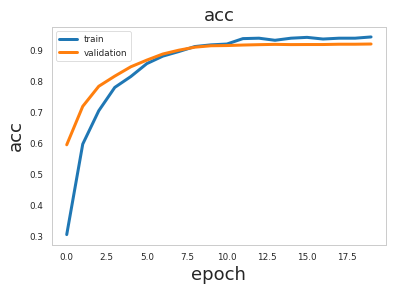

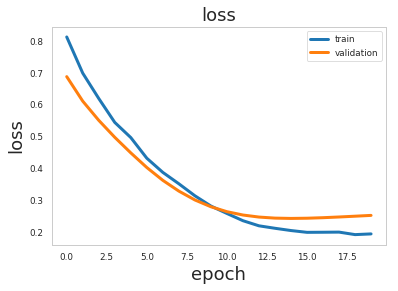

In [41]:
plot_history(history)

### Model Evaluation

Now we have trained the model, let's evaluate it on the test set.

We are going to consider 4 evaluation metrics calculated on the test set: Accuracy, Area Under the ROC curve (AU-ROC), the ROC curve, and the confusion table.

#### Accuracy

In [42]:
test_metrics = model.evaluate_generator(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Test Set Metrics:
	loss: 0.2526
	acc: 0.9195


#### AU-ROC

Let's use the trained GNN model to make a prediction for each node in the graph.

Then, select only the predictions for the nodes in the test set and calculate the AU-ROC as another performance metric in addition to the accuracy shown above.

In [43]:
all_nodes = node_data.index
all_gen = generator.flow(all_nodes)

In [44]:
all_predictions = model.predict_generator(all_gen).squeeze()[..., np.newaxis]

In [45]:
all_predictions.shape

(100386, 1)

In [46]:
all_predictions_df = pd.DataFrame(all_predictions, 
                                  index=node_data.index)

Let's extract the predictions for the test data only.

In [47]:
test_preds = all_predictions_df.loc[test_data.index, :]

In [48]:
test_preds.shape

(4226, 1)

The predictions are the probability of the true class that in this case is the probability of a user being hateful.

In [49]:
test_preds.head()

,0
11717,0.932347
63824,0.134444
19161,0.072746
57412,0.000031
98222,0.026793


In [50]:
test_predictions = test_preds.values
test_predictions_class = ((test_predictions>0.5)*1).flatten()
test_df = pd.DataFrame({"Predicted_score": test_predictions.flatten(), 
                        "Predicted_class": test_predictions_class, 
                        "True": test_targets[:,0]})
roc_auc = metrics.roc_auc_score(test_df['True'].values, 
                                test_df['Predicted_score'].values)
print("The AUC on test set:\n")
print(roc_auc)

The AUC on test set:

0.8632811580760491


#### Confusion table

In [51]:
pd.crosstab(test_df['True'], test_df['Predicted_class'])

Predicted_class,0,1
True,,
0,3641,122
1,218,245


#### ROC curve

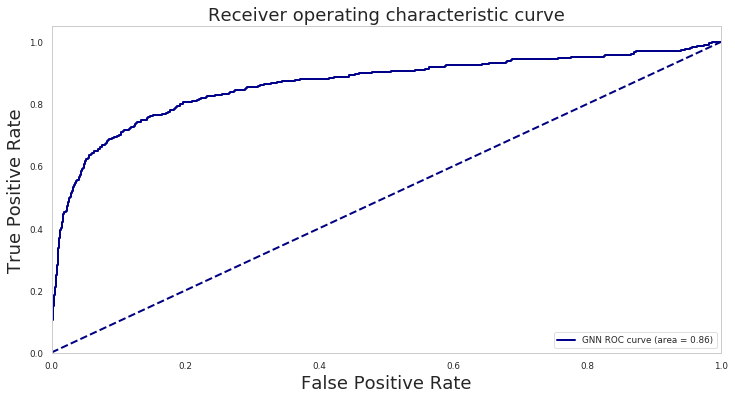

In [52]:
fpr, tpr, thresholds = metrics.roc_curve(test_df['True'], test_df['Predicted_score'], pos_label=1)
plt.figure(figsize=(12,6,))

lw = 2
plt.plot(fpr, tpr, color='darkblue',
         lw=lw, label='GNN ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()

## Interpretability by Saliency Maps

To understand which features and edges the model is looking at while making the predictions, we use the interpretability tool in the StellarGraph library (i.e., saliency maps) to demonstrate the importance of node features and edges given a target user.

In [54]:
from stellargraph.utils.saliency_maps import IntegratedGradients
int_saliency = IntegratedGradients(model, train_gen)

In [57]:
from stellargraph.utils.saliency_maps import IntegratedGradients, GradientSaliency
#select a user of interest
predicted_hateful = np.where(test_predictions_class == 1)[0]
predicted_normal = np.where(test_predictions_class == 0)[0]
hateful_idx = predicted_hateful[0]
normal_idx = predicted_normal[0]
target_idx_hateful = int(test_data.index[hateful_idx])
target_idx_non_hateful = int(test_data.index[normal_idx])
print('Predicted hateful user of interest - [id:{}], predicted normal user of interest - [id:{}]'.format(target_idx_hateful, target_idx_non_hateful))
print('Ground truth class of the two users are {} and {}'.format(test_targets[hateful_idx], test_targets[normal_idx]))
print('Predicted score: node {}: {}, node {}: {}'.format(target_idx_hateful, all_predictions[target_idx_hateful],target_idx_non_hateful, all_predictions[target_idx_non_hateful]  ))

Predicted hateful user of interest - [id:11717], predicted normal user of interest - [id:63824]
Ground truth class of the two users are [1] and [0]
Predicted score: node 11717: [0.9323475], node 63824: [0.13444439]


We then calculate the importance of the features for each node in the graph. Our sparse support for saliency maps makes it efficient to fit the scale like this dataset.

In [119]:
node_feature_importance = int_saliency.get_integrated_node_masks(hateful_idx, 0)
node_importance = np.sum(node_feature_importance, axis=-1)
node_importance_rank = np.argsort(node_importance)[::-1]

We then analyze the feature importance of the top-250 important nodes. 

In [118]:
feature_names = annotated_users.keys()[1:].values
feature_importance_rank = np.argsort(node_feature_importance[hateful_idx])[::-1]
df = pd.DataFrame([([k] + list(feature_names[np.argsort(node_feature_importance[k])[::-1]])) for k in node_importance_rank[:250]], columns = range(205)) 
df

,0,1,2,3,4,5,6,7,8,9,...,195,196,197,198,199,200,201,202,203,204
0,60059,messaging_empath,rural_empath,aggression_empath,help_empath,listed_count,number urls,air_travel_empath,wealthy_empath,independence_empath,...,competing_empath,money_empath,pain_empath,positive_emotion_empath,youth_empath,masculine_empath,sexual_empath,negotiate_empath,pet_empath,power_empath
1,0,messaging_empath,attractive_empath,movement_empath,masculine_empath,sexual_empath,journalism_empath,liquid_empath,celebration_empath,strength_empath,...,weapon_empath,work_empath,politics_empath,cold_empath,shame_empath,medieval_empath,poor_empath,air_travel_empath,lust_empath,rural_empath
2,96765,messaging_empath,independence_empath,number urls,hygiene_empath,sexual_empath,wealthy_empath,statuses_count,fire_empath,injury_empath,...,rural_empath,water_empath,air_travel_empath,meeting_empath,torment_empath,poor_empath,movement_empath,aggression_empath,listed_count,tweet number
3,7729,messaging_empath,hygiene_empath,negotiate_empath,sexual_empath,independence_empath,college_empath,lust_empath,tweet number,medical_emergency_empath,...,valuable_empath,philosophy_empath,meeting_empath,programming_empath,fire_empath,rage_empath,liquid_empath,listed_count,followers_count,attractive_empath
4,73761,messaging_empath,college_empath,rage_empath,tweet number,number urls,poor_empath,movement_empath,programming_empath,number hashtags,...,fun_empath,medieval_empath,science_empath,lust_empath,aggression_empath,family_empath,meeting_empath,followers_count,air_travel_empath,listed_count
5,96239,rural_empath,messaging_empath,politics_empath,contentment_empath,hygiene_empath,negotiate_empath,fight_empath,wealthy_empath,air_travel_empath,...,rage_empath,followers_count,horror_empath,injury_empath,torment_empath,aggression_empath,meeting_empath,strength_empath,positive_emotion_empath,independence_empath
6,93786,tweet number,pet_empath,farming_empath,poor_empath,family_empath,number urls,programming_empath,negotiate_empath,number hashtags,...,help_empath,college_empath,statuses_count,wealthy_empath,masculine_empath,meeting_empath,cold_empath,sexual_empath,listed_count,air_travel_empath
7,84042,number urls,listed_count,tweet number,followers_count,dominant_heirarchical_empath,fight_empath,clothing_empath,cold_empath,horror_empath,...,occupation_empath,exasperation_empath,programming_empath,morning_empath,celebration_empath,timidity_empath,poor_empath,shame_empath,aggression_empath,lust_empath
8,36538,medical_emergency_empath,messaging_empath,movement_empath,farming_empath,college_empath,cold_empath,dance_empath,valuable_empath,independence_empath,...,work_empath,love_empath,legend_empath,negative_emotion_empath,pride_empath,meeting_empath,lust_empath,pet_empath,weapon_empath,sexual_empath
9,8087,positive_emotion_empath,college_empath,injury_empath,movement_empath,politics_empath,independence_empath,tweet number,ridicule_empath,rural_empath,...,pain_empath,medieval_empath,followers_count,restaurant_empath,masculine_empath,sexual_empath,wealthy_empath,air_travel_empath,lust_empath,listed_count


It seems the important features for the top important nodes are quite consistent. For example, `messaging_empath` is the most important feature for the top-5 important nodes. It also acts as one of the most important features for the majority of the top-250 important nodes. Similarly, the `listed_count` acts as the least important feature for most of the selected nodes.

In [ ]:
self_feature_importance_rank = np.argsort(node_feature_importance[target_idx_hateful])
print(node_importance_rank.tolist().index(target_idx_hateful))
df = pd.DataFrame([feature_names[self_feature_importance_rank][::-1]], columns = range(204)) 
df

We now analyze the average feature importance rank for the above selected nodes.

In [122]:
from collections import defaultdict
average_feature_rank = defaultdict(int)
for i in node_importance_rank[:250]:
    feature_rank = list(feature_names[np.argsort(node_feature_importance[i])[::-1]])
    for j in range(len(feature_rank)):
        average_feature_rank[feature_rank[j]] += feature_rank.index(feature_rank[j])
for k in average_feature_rank.keys():
    average_feature_rank[k] /= 250.0
sorted_avg_feature_rank = sorted(average_feature_rank.items(), key=lambda a:a[1])
print(sorted_avg_feature_rank)

[('messaging_empath', 37.252), ('politics_empath', 43.132), ('number hashtags', 44.656), ('fire_empath', 45.664), ('ridicule_empath', 46.604), ('negotiate_empath', 49.304), ('liquid_empath', 49.428), ('farming_empath', 52.624), ('valuable_empath', 54.96), ('traveling_empath', 56.356), ('science_empath', 58.684), ('independence_empath', 59.868), ('hygiene_empath', 61.112), ('baddies', 62.624), ('positive_emotion_empath', 63.344), ('college_empath', 65.632), ('tweet number', 70.648), ('attractive_empath', 70.804), ('home_empath', 70.864), ('horror_empath', 71.24), ('journalism_empath', 71.508), ('medical_emergency_empath', 71.768), ('dance_empath', 72.008), ('eating_empath', 72.272), ('movement_empath', 72.624), ('contentment_empath', 72.644), ('aggression_empath', 73.044), ('dominant_heirarchical_empath', 73.696), ('injury_empath', 74.272), ('time_diff', 75.02), ('hipster_empath', 75.04), ('cold_empath', 75.104), ('sleep_empath', 75.24), ('listen_empath', 75.264), ('programming_empath',

In [62]:
link_importance = int_saliency.get_integrated_link_masks(hateful_idx, 0)

In [63]:
print(link_importance.shape)

(100386, 100386)


In [108]:
(x, y) = link_importance.nonzero()

In [124]:
nonzero_importance_val = link_importance[(x,y)]
link_importance_rank = np.argsort(nonzero_importance_val)[::-1]
x_rank, y_rank = x[link_importance_rank], y[link_importance_rank]
print('The most important edge connects {}-th important node and {}-th important node'.format(node_importance_rank.tolist().index(x_rank[0][-1]), (node_importance_rank.tolist().index(y_rank[0][-1]))))

The most important edge connects 1-th important node and 199-th important node


We then check what happens if we perturb the top-10 most important edges.

In [144]:
from copy import deepcopy
[X,_,A_index, A], y_true_all = all_gen[0]
A_perturb = deepcopy(A)
print(A_perturb.shape)
print(A_index.shape)
selected_nodes = np.array([[target_idx_hateful]], dtype='int32')
print('A_perturb.shape = {}'.format(A_perturb.shape))
for i in range(1, 10):
    edge_x, edge_y = x_rank[0,-i],y_rank[0, -i]
    edge_index = A_index[0].tolist().index([edge_x,edge_y])
    print('remove edge {} -> {}'.format(edge_x, edge_y))
    A_perturb[0, edge_index] = 0
prediction = model.predict([X, selected_nodes, A_index, A_perturb]).squeeze()


(1, 4289572)
(1, 4289572, 2)
A_perturb.shape = (1, 4289572)
remove edge 0 -> 47995
remove edge 88397 -> 60059
remove edge 0 -> 30272
remove edge 0 -> 44642
remove edge 1 -> 7729
remove edge 40522 -> 96765
remove edge 60298 -> 96239
remove edge 0 -> 48834
remove edge 7435 -> 84042


In [145]:
print(prediction)

0.00028415903


As one may notice, none of the edges are directly connected to the target node. Nevertheless, removing them drastically flips the prediction of the target node.